# Project - Data Wrangling
### This notebook is used for data wrangling and EDA on Twitter data
#### Data source:
- <a href='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv'> Twitter archive from Udacity</a>
- <a href='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'> Image prediction result in TSV</a>
- <a href='https://developer.twitter.com/en/docs/tweets/post-and-engage/overview'>Twitter data retrived from Twitter API</a>

## Import libraries and define important variables

In [1]:
import pandas as pd
import numpy as np
import requests
import os
import random
import json
import re
import matplotlib.pyplot as plt
import statsmodels.api as sm

pd.set_option('display.max_colwidth', -1)
%matplotlib inline

In [2]:
# Define variable
prediction_url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv" 
twitter_archive_path = os.path.join("data", "twitter-archive-enhanced.csv")
prediction_path = os.path.join("data", "image-predictions.tsv")
tweet_json_path = os.path.join("data", "tweet-json.txt")
twitter_master_path = os.path.join("data", "")

# Replace it with your own API keys, secrets, and tokens
api_consumer_key = None
api_consumer_secret = None
api_access_token = None
api_access_secret = None

## Data Gathering

In [3]:
# Download image-predictions.tsv if it doesn't exist
if not os.path.exists(prediction_path):    
    with open(prediction_path, mode="wb") as file:
        file.write(requests.get(prediction_url).content)

In [4]:
# Retrived data from Twitter API if the file not exist
if not os.path.exists(tweet_json_path):
    auth = tweepy.OAuthHandler(api_consumer_key, api_consumer_secret)
    auth.set_access_token(api_access_token, api_access_secret)
    api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)
    with open('tweet_json.txt', mode='w') as f:
        for tweet_id in twitter_archive['tweet_id']:
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                json.dump(tweet._json, f)
                f.write('\n')
            except:
                continue

## Data Assessing and Cleaning

Changes need:

`twitter-archive-enhanced.csv`

**Quality**
- timestamp should be in datetime type
- retweeted_status_timestamp should be in datetime type
- retweeted_status_id should be in int type
- retweeted_status_user_id should be in int type
- remove the retweet post
- expended_urls should be in list type
- some inconsistent values for rating numerator and rating denominator

**Tidiness**
- the link in text column should be seperated
- the stage should be melt into a single column


`images-prediction.tsv`

**Quality**
- breed predition should be all in lower case
- p1, p2 and p3 should be in categorical type

**Tidiness**
- aggregate classifier models result
- remove unuse columns
- merge it with twitter-archive-enhanced

`twitter-json`

**Tidiness**
- remove unuse columns
- merge it with twitter-archive-enhanced


### twitter-archive-enhanced.csv

#### Data Assessing

In [5]:
df_archive = pd.read_csv(twitter_archive_path)
df_archive.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None


In [6]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [7]:
df_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [8]:
df_archive[df_archive.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [9]:
# Investigate text column
print(random.choices(df_archive.text, k=5))

# Observation:
# - The text contains rating numerator (RN) and rating denominator (RD) in the form of RN/RD
# - The text contains post link 

["I would do radical things in the name of Dog God. I'd believe every word in that book. 10/10 https://t.co/9ZuGAmLZDR", "This is Reginald. He's pondering what life would be like without so much damn skin. 9/10 it'll be ok buddy https://t.co/1U5Ro5FA4c", 'Here we have an Austrian Pulitzer. Collectors edition. Levitates (?). 7/10 would garden with https://t.co/NMQq6HIglK', "Name a more iconic quartet... I'll wait. 13/10 for all https://t.co/kCLgD8687T", "This is Curtis. He's an Albino Haberdasher. Terrified of dandelions. They really spook him up. 10/10 it'll be ok pup https://t.co/s8YcfZrWhK"]


In [10]:
# Investigate expanded urls
df_archive[df_archive.expanded_urls.duplicated(keep=False)].sort_values(by='expanded_urls')

# Observation:
# - The duplicated urls are the retweeted post

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
349,831650051525054464,NaN,NaN,2017-02-14 23:43:18 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","I usually only share these on Friday's, but this is Blue. He's a very smoochable pooch who needs your help. 13/10\n\nhttps://t.co/piiX0ke8Z6 https://t.co/1UHrKcaCiO",NaN,NaN,NaN,"http://www.gofundme.com/bluethewhitehusky,https://twitter.com/dog_rates/status/831650051525054464/photo/1,https://twitter.com/dog_rates/status/831650051525054464/photo/1,https://twitter.com/dog_rates/status/831650051525054464/photo/1,https://twitter.com/dog_rates/status/831650051525054464/photo/1",13,10,None,None,None,None,None
204,852936405516943360,NaN,NaN,2017-04-14 17:27:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: I usually only share these on Friday's, but this is Blue. He's a very smoochable pooch who needs your help. 13/10\n\nhttps://t…",8.316501e+17,4.196984e+09,2017-02-14 23:43:18 +0000,"http://www.gofundme.com/bluethewhitehusky,https://twitter.com/dog_rates/status/831650051525054464/photo/1,https://twitter.com/dog_rates/status/831650051525054464/photo/1,https://twitter.com/dog_rates/status/831650051525054464/photo/1,https://twitter.com/dog_rates/status/831650051525054464/photo/1",13,10,None,None,None,None,None
2338,666104133288665088,NaN,NaN,2015-11-16 04:02:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/Asgdc6kuLX,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666104133288665088/photo/1,1,10,None,None,None,None,None
605,798576900688019456,NaN,NaN,2016-11-15 17:22:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/…,6.661041e+17,4.196984e+09,2015-11-16 04:02:55 +0000,https://twitter.com/dog_rates/status/666104133288665088/photo/1,1,10,None,None,None,None,None
2294,667138269671505920,NaN,NaN,2015-11-19 00:32:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Extremely intelligent dog here. Has learned to walk like human. Even has his own dog. Very impressive 10/10 https://t.co/0DvHAMdA4V,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667138269671505920/photo/1,10,10,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1940,673716320723169284,6.737159e+17,4.196984e+09,2015-12-07 04:11:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The millennials have spoken and we've decided to immediately demote to a 1/10. Thank you,NaN,NaN,NaN,NaN,1,10,None,None,None,None,None
2038,671550332464455680,6.715449e+17,4.196984e+09,2015-12-01 04:44:10 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",After 22 minutes of careful deliberation this dog is being demoted to a 1/10. The longer you look at him the more terrifying he becomes,NaN,NaN,NaN,NaN,1,10,None,None,None,None,None
2149,669684865554620416,6.693544e+17,4.196984e+09,2015-11-26 01:11:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",After countless hours of research and hundreds of formula alterations we have concluded that Dug should be bumped to an 11/10,NaN,NaN,NaN,NaN,11,10,None,None,None,None,None
2189,668967877119254528,6.689207e+17,2.143566e+07,2015-11-24 01:42:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",12/10 good sh

In [11]:
# Investigate abnormal rating numerator and rating denominator
df_archive.sort_values(by='rating_numerator',ascending=False).head()

# Observation:
# - some values of rating numerator is wrong (can retrieve the correct value from text)
# - some values of rating denominator is wrong (can retrieve the correct value from text)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277374128128/photo/1,1776,10,Atticus,None,None,None,None
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
189,855860136149123072,8.558585e+17,13615722.0,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,194351775.0,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
2074,670842764863651840,NaN,NaN,2015-11-29 05:52:33 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670842764863651840/photo/1,420,10,None,None,None,None,None


#### Data Cleaning

In [12]:
df_archive_clean = df_archive.copy()

In [13]:
# Coverting datatype
df_archive_clean.timestamp = pd.to_datetime(df_archive_clean.timestamp, format="%Y-%m-%d %H:%M:%S")
df_archive_clean.retweeted_status_timestamp = pd.to_datetime(df_archive_clean.retweeted_status_timestamp, format="%Y-%m-%d %H:%M:%S")
df_archive_clean.retweeted_status_id = df_archive_clean.retweeted_status_id.astype('Int64')
df_archive_clean.retweeted_status_user_id = df_archive_clean.retweeted_status_user_id.astype('Int64')

# Verify
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns, UTC]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null Int64
retweeted_status_user_id      181 non-null Int64
retweeted_status_timestamp    181 non-null datetime64[ns, UTC]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: In

In [14]:
# Remove retweet post
df_archive_clean = df_archive_clean[df_archive_clean.retweeted_status_id.isna()]

# Verify
print(f'Remaining row: {df_archive_clean.count()[0]}')

Remaining row: 2175


In [15]:
# Convert expanded url into list form
def convert_to_list(string):
    if type(string) == str:
        return string.split(",")
    else:
        return []

df_archive_clean.expanded_urls = df_archive_clean.expanded_urls.apply(convert_to_list)

# Verify
type(df_archive_clean.expanded_urls[0])

list

In [16]:
# Extract post url from text and move to new column
df_archive_clean['post_url'] = df_archive_clean.text.str.extract(r'(https?://\S+)', expand=True)
df_archive_clean['text'] = df_archive_clean.text.apply(lambda text: re.split('https:\/\/.*', str(text))[0].strip())

# Verify
print(df_archive_clean.text[0])
print(df_archive_clean.post_url[0])
df_archive_clean.head(2)

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10
https://t.co/MgUWQ76dJU


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,post_url
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,NaN,NaN,NaT,[https://twitter.com/dog_rates/status/892420643555336193/photo/1],13,10,Phineas,None,None,None,None,https://t.co/MgUWQ76dJU
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",NaN,NaN,NaT,[https://twitter.com/dog_rates/status/892177421306343426/photo/1],13,10,Tilly,None,None,None,None,https://t.co/0Xxu71qeIV


In [17]:
# Analyse the abnormal rating numerator and denominator after remove retweet post
# Read the real Twitter post by using post url if needed in analysis
diff_rating_ids = []
def search_abnormal(row):
    rating_extration = re.findall(r'(\d{1,4}\/\d{1,3})', row.text)        
    if ((len(rating_extration) > 1) 
        or (row.rating_numerator != int(rating_extration[0].split('/')[0])) 
        or (row.rating_denominator != int(rating_extration[0].split('/')[1]))):
        
        diff_rating_ids.append(row.tweet_id)
        
df_archive_clean.apply(search_abnormal, axis=1)
df_archive_clean[df_archive_clean.tweet_id.isin(diff_rating_ids)][['tweet_id','post_url','expanded_urls','text', 'rating_numerator', 'rating_denominator']]

# Changes needed:
# 835246439529840640: 13/10
# 740373189193256964: 14/10
# 722974582966214656: 13/10
# 716439118184652801: 11/10
# 695064344191721472: 13/10
# 682962037429899265: 10/10
# 666287406224695296: 9/10

,tweet_id,post_url,expanded_urls,text,rating_numerator,rating_denominator
55,881633300179243008,NaN,[],@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,17,10
313,835246439529840640,NaN,[],"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
766,777684233540206592,https://t.co/SuXcI9B7pQ,[https://twitter.com/dog_rates/status/777684233540206592/photo/1],"""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing",12,10
1007,747600769478692864,https://t.co/eUGjGjjFVJ,"[https://twitter.com/dog_rates/status/747600769478692864/photo/1, https://twitter.com/dog_rates/status/747600769478692864/photo/1]",This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively,10,10
1068,740373189193256964,https://t.co/XAVDNDaVgQ,"[https://twitter.com/dog_rates/status/740373189193256964/photo/1, https://twitter.com/dog_rates/status/740373189193256964/photo/1, https://twitter.com/dog_rates/status/740373189193256964/photo/1, https://twitter.com/dog_rates/status/740373189193256964/photo/1]","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP",9,11
1165,722974582966214656,https://t.co/eV1diwds8a,[https://twitter.com/dog_rates/status/722974582966214656/photo/1],Happy 4/20 from the squad! 13/10 for all,4,20
1202,716439118184652801,https://t.co/Kky1DPG4iq,[https://twitter.com/dog_rates/status/716439118184652801/photo/1],This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10,50,50
1222,714258258790387713,https://t.co/Akzl5ynMmE,[https://twitter.com/dog_rates/status/714258258790387713/photo/1],Meet Travis and Flurp. Travis is pretty chill but Flurp can't lie down properly. 10/10 &amp; 8/10\nget it together Flurp,10,10
1359,703356393781329922,https://t.co/8rc5I22bBf,[https://twitter.com/dog_rates/status/703356393781329922/photo/1],This is Socks. That water pup w the super legs just splashed him. Socks did not appreciate that. 9/10 and 2/10,9,10
1459,695064344191721472,https://t.co/uaJmNgXR2P,[https://twitter.com/dog_rates/status/695064344191721472/video/1],"This may be the greatest video I've ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_)",4,10


In [18]:
# Change the rating numerator and rating denominator value manually based on above analysis
rating_changes = {
    835246439529840640: [13,10],
    740373189193256964: [14,10],
    722974582966214656: [13,10],
    716439118184652801: [11,10],
    695064344191721472: [13,10],
    682962037429899265: [10,10],
    666287406224695296: [9,10]
}

for key, value in rating_changes.items():
    df_archive_clean.loc[df_archive_clean.tweet_id == key, "rating_numerator"] = value[0]
    df_archive_clean.loc[df_archive_clean.tweet_id == key, "rating_denominator"] = value[1]

# Verify
df_archive_clean[df_archive_clean.tweet_id.isin(rating_changes.keys())][['tweet_id', 'rating_numerator', 'rating_denominator']]

,tweet_id,rating_numerator,rating_denominator
313,835246439529840640,13,10
1068,740373189193256964,14,10
1165,722974582966214656,13,10
1202,716439118184652801,11,10
1459,695064344191721472,13,10
1662,682962037429899265,10,10
2335,666287406224695296,9,10


In [19]:
# Remove rating numerator and rating denominator from text and some special character
def get_rating(row):
    remove_items = re.findall(r'(\d{1,4}\/\d{1,3})', row.text)
    remove_items + ['\n', '&amp;']
    new_text = row.text    
    for item in remove_items:
        new_text = re.split(r'(\d{1,4}\/\d{1,3})', new_text)
        new_text.remove(item)
        new_text = map(str.strip, new_text)
        new_text = ' '.join(new_text).strip()
    row.text = new_text
    return row

df_archive_clean = df_archive_clean.apply(get_rating, axis=1)

# Verify
df_archive_clean.text.sample(5)

1538    Meet Fynn &amp; Taco. Fynn is an all-powerful leaf lord and Taco is in the wrong place at the wrong time. &amp;
810     Meet Fizz. She thinks love is a social construct consisting solely of ideals perpetuated by mass media woke af 
620     #ImWithThor                                                                                                    
1697    I just love this pic. this pupper is going places                                                              
721     This is Dave. He's currently in a predicament. Doesn't seem to mind tho. someone assist Dave                   
Name: text, dtype: object

In [20]:
# Melt stage columns into a single column
melt_cols = ['doggo', 'floofer', 'pupper', 'puppo']
def melt_stage(row):
    stage = []
    for x in melt_cols:
        if(row[x] != 'None'):
            stage.append(x)
    if not stage:
        return None
    else:
        return ', '.join(stage)

df_archive_clean['stage'] = df_archive_clean.apply(melt_stage, axis=1)
df_archive_clean = df_archive_clean.drop(columns=melt_cols)

# Verify
df_archive_clean.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,post_url,stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut.,NaN,NaN,NaT,[https://twitter.com/dog_rates/status/892420643555336193/photo/1],13,10,Phineas,https://t.co/MgUWQ76dJU,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit.",NaN,NaN,NaT,[https://twitter.com/dog_rates/status/892177421306343426/photo/1],13,10,Tilly,https://t.co/0Xxu71qeIV,None


### image-predictions.tsv-
#### Data Assessing

In [21]:
df_pred = pd.read_csv(prediction_path, '\t')
df_pred.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [22]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [23]:
df_pred.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [24]:
# Checking duplicated image url 
df_pred.jpg_url.value_counts()

# Observation:
# - Suspected the duplicated image urls are the retweeted posts

https://pbs.twimg.com/media/Cs_DYr1XEAA54Pu.jpg    2
https://pbs.twimg.com/media/CVMOlMiWwAA4Yxl.jpg    2
https://pbs.twimg.com/media/C12x-JTVIAAzdfl.jpg    2
https://pbs.twimg.com/media/CvoBPWRWgAA4het.jpg    2
https://pbs.twimg.com/media/CxqsX-8XUAAEvjD.jpg    2
                                                  ..
https://pbs.twimg.com/media/Cb78-nOWIAENNRc.jpg    1
https://pbs.twimg.com/media/C32wOLcWYAAjNqS.jpg    1
https://pbs.twimg.com/media/CVG_2I-WIAASKSS.jpg    1
https://pbs.twimg.com/media/Crcc7pqXEAAM5O2.jpg    1
https://pbs.twimg.com/media/CU3be0SWEAEqb7I.jpg    1
Name: jpg_url, Length: 2009, dtype: int64

#### Data Cleaning

In [25]:
df_pred_clean = df_pred.copy()

In [26]:
# Covert the value in column p1, p2, p3 to lower case
df_pred_clean['p1'] = df_pred_clean['p1'].str.lower()
df_pred_clean['p2'] = df_pred_clean['p2'].str.lower()
df_pred_clean['p3'] = df_pred_clean['p3'].str.lower()

# Verify
df_pred_clean.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True


In [27]:
# Covert data type of column p1, p2, p3
df_pred_clean.p1 = df_pred_clean.p1.astype('category')
df_pred_clean.p2 = df_pred_clean.p2.astype('category')
df_pred_clean.p3 = df_pred_clean.p3.astype('category')

# Verify
df_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null category
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null category
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null category
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), category(3), float64(3), int64(2), object(1)
memory usage: 174.9+ KB


In [28]:
# Retrieve breed prediction result 
def get_pred_result(row):
    predictor = ['p1', 'p2', 'p3']
    conf = [0, 0, 0]
    if row.p1_dog == False and row.p2_dog == False and row.p3_dog == False:
        return None
    else:
        for i in range(len(predictor)):
            conf[i] = row[f'{predictor[i]}_dog'] * row[f'{predictor[i]}_conf'] 
        return row[predictor[np.argmax(conf)]]
    
df_pred_clean['breed'] = df_pred_clean.apply(get_pred_result, axis=1)

# Verify
df_pred_clean.sample(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,breed
1875,845677943972139009,https://pbs.twimg.com/media/C7xzmngWkAAAp9C.jpg,1,chow,0.808681,True,groenendael,0.123141,True,newfoundland,0.022143,True,chow
495,675740360753160193,https://pbs.twimg.com/ext_tw_video_thumb/675740268751138818/pu/img/dVaVeFAVT-lk_1ZV.jpg,1,golden_retriever,0.800495,True,kuvasz,0.097756,True,saluki,0.068415,True,golden_retriever
1239,746872823977771008,https://pbs.twimg.com/media/Cl1s1p7WMAA44Vk.jpg,1,pembroke,0.540201,True,beagle,0.207835,True,italian_greyhound,0.043565,True,pembroke


In [29]:
type(np.argmax([14,2,3]))

numpy.int64

### tweet-json.txt
#### Data Assessing

In [30]:
df_tweet = pd.read_json(tweet_json_path, lines=True)
df_tweet.head(2)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': 'https://t.co/MgUWQ76dJU', 'display_url': 'pic.twitter.com/MgUWQ76dJU', 'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1', 'type': 'photo', 'sizes': {'large': {'w': 540, 'h': 528, 'resize': 'fit'}, 'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'small': {'w': 540, 'h': 528, 'resize': 'fit'}, 'medium': {'w': 540, 'h': 528, 'resize': 'fit'}}}]}","{'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': 'https://t.co/MgUWQ76dJU', 'display_url': 'pic.twitter.com/MgUWQ76dJU', 'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1', 'type': 'photo', 'sizes': {'large': {'w': 540, 'h': 528, 'resize': 'fit'}, 'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'small': {'w': 540, 'h': 528, 'resize': 'fit'}, 'medium': {'w': 540, 'h': 528, 'resize': 'fit'}}}]}","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,...,39370,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892177413194625024, 'id_str': '892177413194625024', 'indices': [139, 162], 'media_url': 'http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'url': 'https://t.co/0Xxu71qeIV', 'display_url': 'pic.twitter.com/0Xxu71qeIV', 'expanded_url': 'https://twitter.com/dog_rates/status/892177421306343426/photo/1', 'type': 'photo', 'sizes': {'large': {'w': 1407, 'h': 1600, 'resize': 'fit'}, 'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'small': {'w': 598, 'h': 680, 'resize': 'fit'}, 'medium': {'w': 1055, 'h': 1200, 'resize': 'fit'}}}]}","{'media': [{'id': 892177413194625024, 'id_str': '892177413194625024', 'indices': [139, 162], 'media_url': 'http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'url': 'https://t.co/0Xxu71qeIV', 'display_url': 'pic.twitter.com/0Xxu71qeIV', 'expanded_url': 'https://twitter.com/dog_rates/status/892177421306343426/photo/1', 'type': 'photo', 'sizes': {'large': {'w': 1407, 'h': 1600, 'resize': 'fit'}, 'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'small': {'w': 598, 'h': 680, 'resize': 'fit'}, 'medium': {'w': 1055, 'h': 1200, 'resize': 'fit'}}}]}","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,...,33698,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN


#### Data Cleaning

In [31]:
# Remove unuse cloumn
df_tweet = df_tweet[['id', 'retweet_count', 'favorite_count']]

# Verify
df_tweet.head(2)

,id,retweet_count,favorite_count
0,892420643555336193,8795,39370
1,892177421306343426,6448,33698


In [32]:
# Join 3 of the tables together
df_fin = df_archive_clean.set_index('tweet_id').join(df_pred_clean.set_index('tweet_id'))
df_fin.reset_index(inplace=True)
df_fin = df_fin.set_index('tweet_id').join(df_tweet.set_index('id'))
df_fin = df_fin.sort_values(by='tweet_id')
df_fin.reset_index(inplace=True)

# Verify
df_fin.tail(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,breed,retweet_count,favorite_count
2173,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit.",NaN,NaN,NaT,[https://twitter.com/dog_rates/status/892177421306343426/photo/1],...,True,pekinese,0.090647,True,papillon,0.068957,True,chihuahua,6448,33698
2174,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut.,NaN,NaN,NaT,[https://twitter.com/dog_rates/status/892420643555336193/photo/1],...,False,bagel,0.085851,False,banana,0.076110,False,None,8795,39370


In [33]:
# Revisit the suspection about jpg_url made above
df_fin.jpg_url.value_counts()

# Observation:
# - The suspection was valid and no duplicated image after merged with df_archive_clean

https://pbs.twimg.com/media/C-wLyufW0AA546I.jpg    1
https://pbs.twimg.com/media/CUJIFoJWsAAL3Dc.jpg    1
https://pbs.twimg.com/media/CYLAWFMWMAEcRzb.jpg    1
https://pbs.twimg.com/media/Cd1tYGmXIAAoW5b.jpg    1
https://pbs.twimg.com/media/C4KHj-nWQAA3poV.jpg    1
                                                  ..
https://pbs.twimg.com/media/ClRoXGwWIAEVVzc.jpg    1
https://pbs.twimg.com/media/C61lFFiWoAAJdiL.jpg    1
https://pbs.twimg.com/media/CVBCFkyU4AE2Wcr.jpg    1
https://pbs.twimg.com/media/C17n1nrWQAIErU3.jpg    1
https://pbs.twimg.com/media/CU3be0SWEAEqb7I.jpg    1
Name: jpg_url, Length: 1994, dtype: int64

In [34]:
df_fin.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,breed,retweet_count,favorite_count
0,666020888022790149,NaN,NaN,2015-11-15 22:32:08+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. would pet,NaN,NaN,NaT,[https://twitter.com/dog_rates/status/666020888022790149/photo/1],...,True,collie,0.156665,True,shetland_sheepdog,0.061428,True,welsh_springer_spaniel,527,2528


In [35]:
df_fin.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'post_url', 'stage', 'jpg_url', 'img_num',
       'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog', 'breed', 'retweet_count', 'favorite_count'],
      dtype='object')

In [36]:
# Remove unuse column
unused_cols=[
    'in_reply_to_status_id', 
    'in_reply_to_user_id', 
    'source', 
    'retweeted_status_id', 
    'retweeted_status_user_id', 
    'retweeted_status_timestamp', 
    'post_url', 
    'jpg_url',
    'img_num',
]

df_fin = df_fin.drop(unused_cols, axis=1)

# Verify
df_fin.head(2)

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,stage,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,breed,retweet_count,favorite_count
0,666020888022790149,2015-11-15 22:32:08+00:00,Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. would pet,[https://twitter.com/dog_rates/status/666020888022790149/photo/1],8,10,None,None,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True,welsh_springer_spaniel,527,2528
1,666029285002620928,2015-11-15 23:05:30+00:00,This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. would walk the shit out of,[https://twitter.com/dog_rates/status/666029285002620928/photo/1],7,10,a,None,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True,redbone,47,132


### Store the processed dataset

In [37]:
df_fin.to_csv(twitter_master_path, index=False)

## Data Analysis

### The relationship between retweet count and favorite count

Text(0, 0.5, 'Number of favourite')

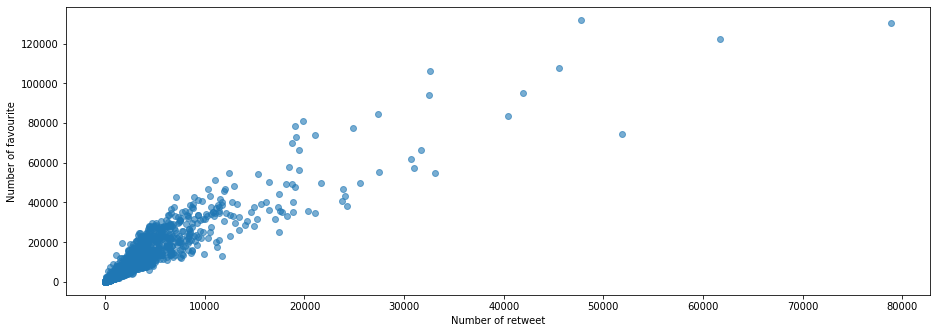

In [38]:
df = df_fin.copy()
fig=plt.figure()
fig.add_axes([0,0,2,1])
plt.scatter(df.retweet_count, df.favorite_count, alpha=0.6)
plt.xlabel('Number of retweet')
plt.ylabel('Number of favourite')

In [39]:
df['intercept'] = 1
lin_model = sm.OLS(df.favorite_count, df[['intercept', 'retweet_count']]).fit()
lin_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         favorite_count   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                 1.118e+04
Date:                Tue, 14 Apr 2020   Prob (F-statistic):               0.00
Time:                        18:55:41   Log-Likelihood:                -21590.
No. Observations:                2175   AIC:                         4.318e+04
Df Residuals:                    2173   BIC:                         4.319e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      2187.6048    123.077     17.774      0.000    1946.243    2428.966
retweet_count     2.3875      0.023    105.752      0.000       2.343       2.432
==============================================================================
Omnibus:                      553.168   Durbin-Watson:                   0.830
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38587.209
Skew:                          -0.030   Prob(JB):                         0.00
Kurtosis:                      23.635   Cond. No.                     6.32e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.32e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
corr_coef = np.sqrt(0.837)
corr_coef

0.9148770409186143

- The variable retweet_count and favorite_count have a strong positive corelation coefficient which is approximate 0.9149
- Retweet count is statistically significant in relating to favourite count
- For each retweet count increase in the post, we can expect the favorite count to increase by 2.3875.

### The ratio of the successful and fail that the classifier predict as dog for the images

([<matplotlib.patches.Wedge at 0x2c1fe641108>,
 [Text(0.8368333899834639, 0.7139396875148376, 'failed to predict'),
  Text(-0.8368333899834639, -0.7139396875148376, 'predicted as dog')],
 [Text(0.4564545763546166, 0.38942164773536597, '22.48%'),
  Text(-0.4564545763546166, -0.38942164773536597, '77.52%')])

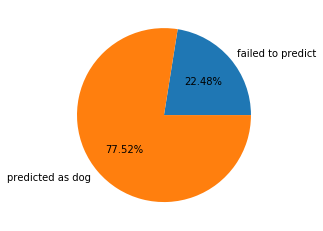

In [41]:
plt.pie([df[df.breed.isna()].count()[0], df[df.breed.notna()].count()[0]], labels = ['failed to predict', 'predicted as dog'],autopct='%1.2f%%')

- There were only 77.52% of images had successfully predicted as dog among all the images in dataset
- 22.48% of remained images were failed to capture by the classier and predict as not dog

### The top 10 dog breed in the dataset

<BarContainer object of 10 artists>

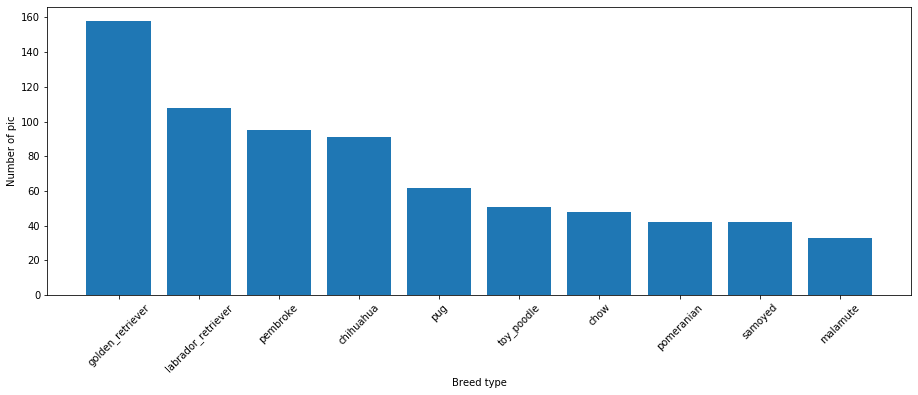

In [42]:
fig=plt.figure()
fig.add_axes([0,0,2,1])
plt.xlabel("Breed type")
plt.ylabel("Number of pic")
plt.xticks(rotation=45)
plt.bar(df[df.breed.notna()].breed.value_counts().index.tolist()[:10], df[df.breed.notna()].breed.value_counts().tolist()[:10])

- The top breed as the classifier predicted is golden retriever with the number of 158 then followed by labrador retriever (108), pembroke (95), chihuahua (91), pug (62), toy_poodle (51), chow (48), pomeranian (42), samoyed (42), malamute (33).
